# LDA

LDA(Latent Dirichlet Allocation) learning using Gibbs sampler and vafiational inference. 

## 0. Initialize

In [1]:
#mathematics
using LinearAlgebra
using SpecialFunctions

#statistics
using Random
using Statistics
using Distributions

#visualize
using Plots
pyplot()

#macros
using UnPack
using ProgressMeter

## 1. create data

In [2]:
function create_data(αvec, βvec, K, V, D, Nds)
    n_words = sum(Nds)
    Θ = zeros(K, D) #topic probability θd vectors
    Z = zeros(Int64, n_words) #topic vector
    Φ = zeros(V, K) #topic probability ϕk vectors
    W = zeros(Int64, n_words) #word vector
    
    #create topic 
    for k in 1:K
        Φ[:,k] = rand(Dirichlet(βvec))
    end
    
    #create words
    idx = 0
    for d in 1:D
        Θ[:,d] = rand(Dirichlet(αvec))
        for i in 1:Nds[d]
            idx += 1
            Z[idx] = rand(Categorical(Θ[:,d]))
            W[idx] = rand(Categorical(Φ[:,Z[idx]]))
        end
    end
    return W, Z, Θ, Φ
end

create_data (generic function with 1 method)

In [3]:
#set the random seed
Random.seed!(42)

#paramters
D = 100
K = 10
V = 700
Nds = rand(Poisson(10), D)
αvec = 2*rand(K)/K
βvec = 10*rand(V)/V

#data
W, Z_true, Θ_true, Φ_true = create_data(αvec, βvec, K, V, D, Nds)
data = (W=W, D=D, V=V, Nds=Nds)

(W = [572, 572, 8, 122, 516, 572, 297, 516, 127, 8  …  156, 122, 122, 255, 122, 126, 700, 122, 124, 122], D = 100, V = 700, Nds = [8, 8, 10, 9, 15, 6, 10, 18, 11, 7  …  9, 10, 8, 7, 8, 8, 7, 9, 8, 9])

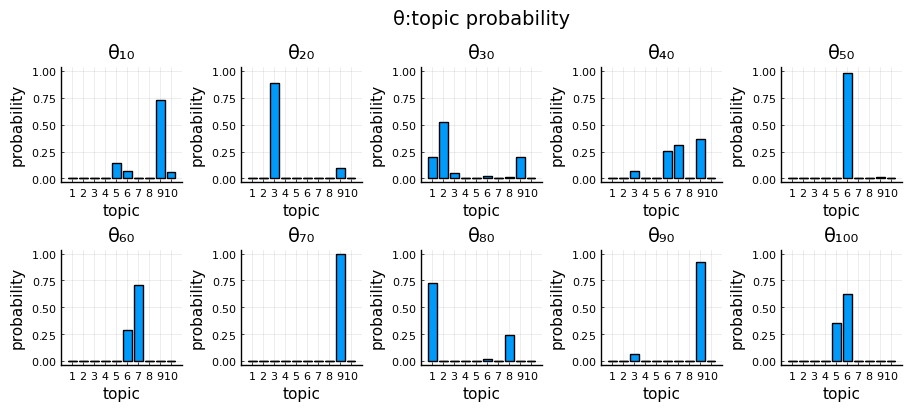

In [4]:
#θ
title = plot(title="θ:topic probability", grid=false, showaxis = false, ticks = false)
local_titles = ["θ₁₀", "θ₂₀", "θ₃₀", "θ₄₀", "θ₅₀", "θ₆₀", "θ₇₀", "θ₈₀", "θ₉₀", "θ₁₀₀"]
plot_array = []
for i in 1:10
    p = plot(1:K, Θ_true[:,10*i], st=:bar, label=false, ylim=[0,1], xticks=1:K, title=local_titles[i]
        , xlabel="topic", ylabel="probability")
    push!(plot_array, p)
end
fig1 = plot(title, plot_array..., layout=@layout[a{0.01h}; grid(2,5)], size=(900,400))
savefig("figs-LDA/fig1.png")

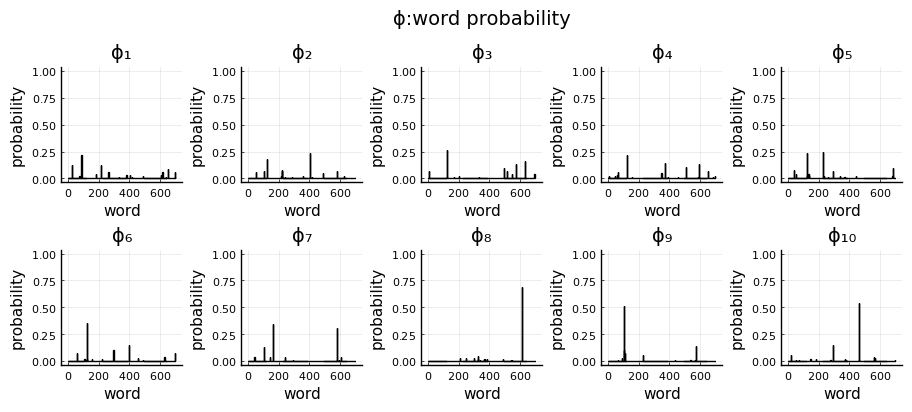

In [5]:
#ϕ
title = plot(title="ϕ:word probability", grid=false, showaxis = false, ticks = false)
local_titles = ["ϕ₁", "ϕ₂", "ϕ₃", "ϕ₄", "ϕ₅", "ϕ₆", "ϕ₇", "ϕ₈", "ϕ₉", "ϕ₁₀"]
plot_array = []
for i in 1:10
    p = plot(1:V, Φ_true[:,i], st=:bar, label=false, ylim=[0,1], xticks=0:200:V, title=local_titles[i]
    , xlabel="word", ylabel="probability")
    push!(plot_array, p)
end
fig2 = plot(title, plot_array..., layout=@layout[a{0.01h}; grid(2,5)], size=(900,400))
savefig("figs-LDA/fig2.png")

## 2. Gibbs sampler

In [6]:
#initialize the probability vectors
function init_probs(αvec, βvec, D, V, K, n_samps)
    Θsamps = zeros(K, D, n_samps)
    Φsamps = zeros(V, K, n_samps) 
    for d in 1:D
        Θsamps[:,d,1] = rand(Dirichlet(αvec))
    end
    for k in 1:K
        Φsamps[:,k,1] = rand(Dirichlet(βvec))
    end
    return Θsamps, Φsamps
end

#update probability vector p from p1 and p2
function update_pvec(p1, p2)
    tmp = p1 .* p2
    return tmp/sum(tmp)
end

#update counter
function count(WZcount, Zcount, d, w, z)
    WZcount[w,z] += 1
    Zcount[z,d] += 1
end

function my_Gibbs_sampler(data, model_params, n_samps, n_burnin)
    @unpack W,D,V,Nds = data
    @unpack K,αvec,βvec = model_params
    
    #initialize
    n_words = sum(Nds)
    Θsamps, Φsamps = init_probs(αvec, βvec, D, V, K, n_samps)
    Zsamps = zeros(Int64, n_words, n_samps)
    pvec = zeros(K)
    
    #counter
    Zcount = zeros(K,D)
    WZcount = zeros(V,K)
    
    #sample loop
    idx = 0
    @inbounds @showprogress for s in 2:n_samps
        for d in 1:D
            for i in 1:Nds[d]
                idx += 1
                pvec = update_pvec(Φsamps[W[idx],:,s-1], Θsamps[:,d,s-1])
                Zsamps[idx,s] = rand(Categorical(pvec))
                count(WZcount, Zcount, d, W[idx], Zsamps[idx,s])
            end
            Θsamps[:,d,s] = rand(Dirichlet(αvec + Zcount[:,d]))
        end
        for k in 1:K
            Φsamps[:,k,s] = rand(Dirichlet(βvec + WZcount[:,k]))
        end
        idx = 0
    end
    return Θsamps[:,:,n_burnin:end], Φsamps[:,:,n_burnin:end], Zsamps[:,n_burnin:end]
end

my_Gibbs_sampler (generic function with 1 method)

In [7]:
#model paramters
Random.seed!(42)
K = 10
αvec = ones(K)/K
βvec = 100*ones(V)/V
model_params = (K=K, αvec=αvec, βvec=βvec)

#Gibbs sampler
n_samps = 10000
n_burnin = div(n_samps, 10)
@time Θsamps, Φsamps, Zsamps = my_Gibbs_sampler(data, model_params, n_samps, n_burnin)

#estimates
Θest = mean(Θsamps, dims=3)
Φest = mean(Φsamps, dims=3)
Zest = Zsamps[:,end]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


 16.509211 seconds (57.56 M allocations: 10.856 GiB, 10.98% gc time, 13.35% compilation time)


972-element Vector{Int64}:
  1
  1
  1
  1
  1
  1
 10
  1
  5
  5
  5
  5
  5
  ⋮
  8
  8
  8
  1
  1
  1
  1
  8
  8
  8
  8
  1

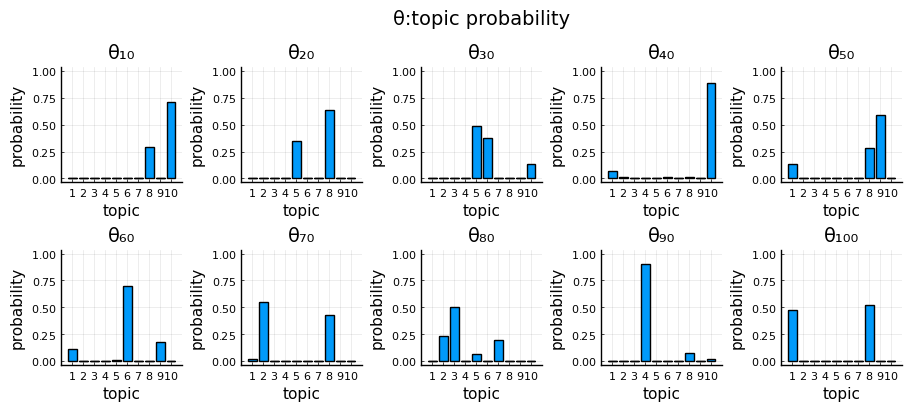

In [8]:
#θ
title = plot(title="θ:topic probability", grid=false, showaxis = false, ticks = false)
local_titles = ["θ₁₀", "θ₂₀", "θ₃₀", "θ₄₀", "θ₅₀", "θ₆₀", "θ₇₀", "θ₈₀", "θ₉₀", "θ₁₀₀"]
plot_array = []
for i in 1:10
    p = plot(1:K, Θest[:,10*i], st=:bar, label=false, ylim=[0,1], xticks=1:K, title=local_titles[i]
    , xlabel="topic", ylabel="probability")
    push!(plot_array, p)
end
fig3 = plot(title, plot_array..., layout=@layout[a{0.01h}; grid(2,5)], size=(900,400))
savefig("figs-LDA/fig3.png")

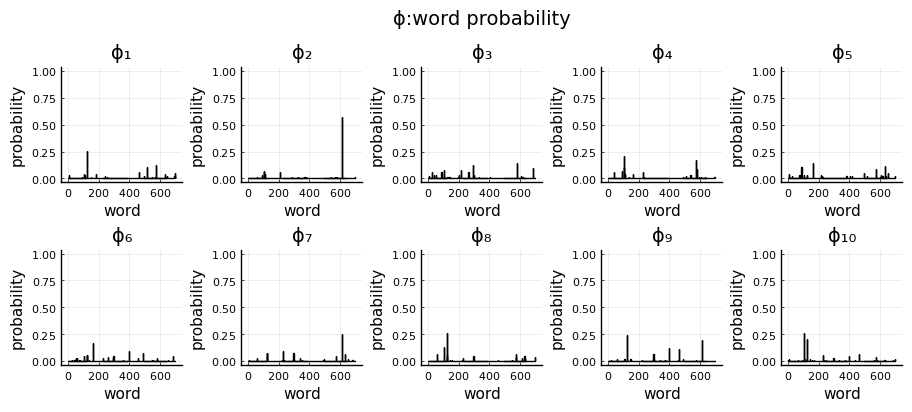

In [9]:
#ϕ
title = plot(title="ϕ:word probability", grid=false, showaxis = false, ticks = false)
local_titles = ["ϕ₁", "ϕ₂", "ϕ₃", "ϕ₄", "ϕ₅", "ϕ₆", "ϕ₇", "ϕ₈", "ϕ₉", "ϕ₁₀"]
plot_array = []
for i in 1:10
    p = plot(1:V, Φest[:,i], st=:bar, label=false, ylim=[0,1], xticks=0:200:V, title=local_titles[i]
    , xlabel="word", ylabel="probability")
    push!(plot_array, p)
end
fig4 = plot(title, plot_array..., layout=@layout[a{0.01h}; grid(2,5)], size=(900,400))
savefig("figs-LDA/fig4.png")

## 3. Variational Inference

In [10]:
#Dirichlet expectation
ElogDir(vec, i) = digamma(vec[i])-digamma(sum(vec))
    
ELBO(pvechats, αvechats, βvechats, αvec, βvec, W, Nds, K, D, ELBO_const) = (
    ELBO_const - sumlogconstDir(αvechats, βvechats, D, K)
    + Evarloglik(pvechats, αvechats, βvechats, W, Nds, D, K)
    + Evarlogpθ(αvechats, αvec, D, K)
    + Evarlogpϕ(βvechats, βvec, V, K)
    - Ezlogrz(pvechats, Nds, D, K)
    - EvarlogrΘ(αvechats, D, K)
    - EvarlogrΦ(βvechats, V, K)
)   

#update probability
function update_prob(αvechats, βvechats, w, d, K)
    pvec = zeros(K)
    for k in 1:K
        pvec[k] = exp(ElogDir(αvechats[:,d], k) + ElogDir(βvechats[:,k], w)) 
    end
    return pvec/sum(pvec)
end

#variational infernce
function myVI(data, model_params, n_train)
    @unpack W,D,V,Nds = data
    @unpack K,αvec,βvec = model_params
    #initialize
    w = 0
    idx = 0
    n_words = sum(Nds)
    αvecs = αvec*ones(D)'
    βvecs = βvec*ones(K)'
    Eθvecs = rand(K,D)
    Eϕvecs = rand(V,K)
    αvechats = αvecs + Eθvecs
    βvechats = βvecs + Eϕvecs
    pvechats = ones(K)/K * ones(n_words)'
    @showprogress for n in 1:n_train
        idx = 0
        for d in 1:D
            for i in 1:Nds[d]
                idx += 1
                w = W[idx]
                for k in 1:K
                    Eθvecs[k,d] += pvechats[k,idx]
                    Eϕvecs[w,k] += pvechats[k,idx]
                end
                pvechats[:,idx] = update_prob(αvechats, βvechats, w, d, K)
            end
        end
        αvechats = αvecs + Eθvecs
        βvechats = βvecs + Eϕvecs
        Eθvecs = zeros(K,D)
        Eϕvecs = zeros(V,K)
    end
    return pvechats, αvechats, βvechats
end

#estimate
function estimate(paramvecs)
    dim,N = size(paramvecs)
    Eparams = zeros(dim,N)
    for n in 1:N
        Eparams[:,n] = paramvecs[:,n]/sum(paramvecs[:,n])
    end
    return Eparams
end

estimate (generic function with 1 method)

In [11]:
#model paramters
Random.seed!(42)
K = 10
αvec = ones(K)/K
βvec = 100*ones(V)/V
model_params = (K=K, αvec=αvec, βvec=βvec)

#variational inference
n_train = 1000
@time pvechats, αvechats, βvechats = myVI(data, model_params, n_train)

#estimates(mean)
Θest = estimate(αvechats)
Φest = estimate(βvechats)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


 35.612728 seconds (22.53 M allocations: 54.062 GiB, 27.87% gc time, 1.23% compilation time)


700×10 Matrix{Float64}:
 0.000940557  0.000502531  0.00648974   …  0.000587345  0.000923286
 0.000940557  0.000499091  0.000815843     0.000587345  0.000923285
 0.000940557  0.000499091  0.000815843     0.000587345  0.000923285
 0.000940557  0.000499091  0.000815843     0.000587345  0.000923285
 0.000940557  0.000499091  0.000815843     0.000587345  0.000923285
 0.000940557  0.000499091  0.000815843  …  0.000587345  0.000923285
 0.000940557  0.00398009   0.000826329     0.000587345  0.000923286
 0.000941237  0.000499185  0.000816237     0.012916     0.000923772
 0.000940557  0.000499091  0.000815843     0.000587345  0.000923285
 0.000940557  0.000499091  0.000815843     0.000587345  0.000923285
 0.000940557  0.000499091  0.000815843  …  0.000587345  0.000923285
 0.000940557  0.000499091  0.000815843     0.000587345  0.000923285
 0.000940557  0.000499091  0.000815843     0.000587345  0.000923285
 ⋮                                      ⋱               
 0.000940557  0.000499091  0.000815

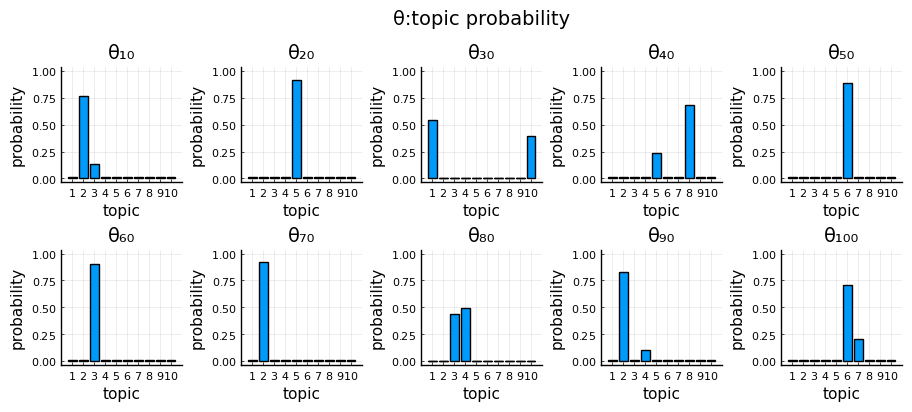

In [12]:
#θ
title = plot(title="θ:topic probability", grid=false, showaxis = false, ticks = false)
local_titles = ["θ₁₀", "θ₂₀", "θ₃₀", "θ₄₀", "θ₅₀", "θ₆₀", "θ₇₀", "θ₈₀", "θ₉₀", "θ₁₀₀"]
plot_array = []
for i in 1:10
    p = plot(1:K, Θest[:,10*i], st=:bar, label=false, ylim=[0,1], xticks=1:K, title=local_titles[i]
    , xlabel="topic", ylabel="probability")
    push!(plot_array, p)
end
fig5 = plot(title, plot_array..., layout=@layout[a{0.01h}; grid(2,5)], size=(900,400))
savefig("figs-LDA/fig5.png")

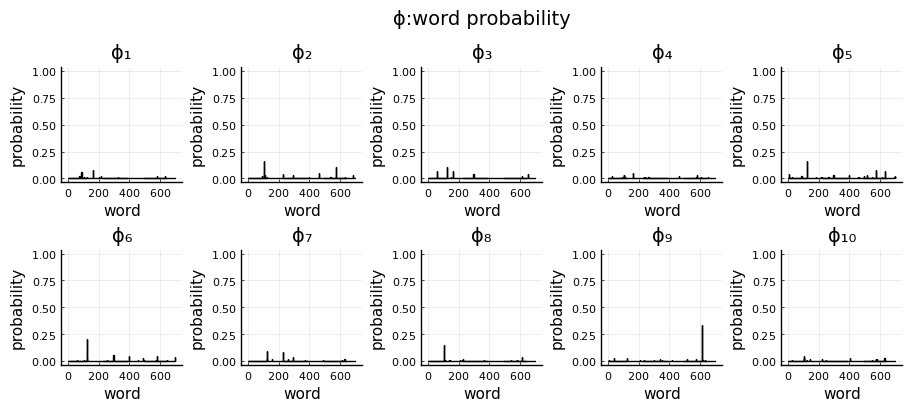

In [13]:
#ϕ
title = plot(title="ϕ:word probability", grid=false, showaxis = false, ticks = false)
local_titles = ["ϕ₁", "ϕ₂", "ϕ₃", "ϕ₄", "ϕ₅", "ϕ₆", "ϕ₇", "ϕ₈", "ϕ₉", "ϕ₁₀"]
plot_array = []
for i in 1:10
    p = plot(1:V, Φest[:,i], st=:bar, label=false, ylim=[0,1], xticks=0:200:V, title=local_titles[i]
    , xlabel="word", ylabel="probability")
    push!(plot_array, p)
end
fig6 = plot(title, plot_array..., layout=@layout[a{0.01h}; grid(2,5)], size=(900,400))
savefig("figs-LDA/fig6.png")